In [1]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data.zip && unzip -q hydranets-data.zip && mv hydranets-data/* . && rm hydranets-data.zip && rm -rf hydranets-data

--2024-10-12 21:29:19--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 3.5.226.172, 3.5.225.205
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|3.5.226.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110752264 (106M) [application/zip]
Saving to: ‘hydranets-data.zip’

hydranets-data.zip  100%[===================>] 105.62M  23.2MB/s    in 5.6s    

2024-10-12 21:29:25 (18.8 MB/s) - ‘hydranets-data.zip’ saved [110752264/110752264]



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable

### Encoder

In [3]:
class HydraNet(nn.Module):
    def __init__(self):
        #super(HydraNet, self).__init__() # Python2
        super().__init__() # Python 3
        self.num_tasks = 2
        self.num_classes = 6
        # self.num_classes = 40

In [4]:
hydranet = HydraNet()

In [5]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, bias=bias, groups=groups)

In [6]:
def conv1x1(in_channels, out_channels, stride=1, dilation=0, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=dilation, bias=bias, groups=groups)

In [7]:
def batchnorm(num_features):
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

In [8]:
def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
  if act:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels),
                         nn.ReLU6(inplace=True))
  else:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels))

In [9]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
    super().__init__()
    intermed_planes = in_planes * expansion_factor
    self.residual = (in_planes == out_planes) and (stride == 1)
    self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                convbnrelu(intermed_planes, out_planes, 1, act=False))
  def forward(self, x):
    if self.residual:
      return x + self.output(x)
    else:
      return self.output(x)

In [10]:
def define_mobilenet(self):
  mobilenet_config = [[1, 16, 1, 1],
                      [6, 24, 2, 2],
                      [6, 32, 3, 2],
                      [6, 64, 4, 2],
                      [6, 96, 3, 1],
                      [6, 160, 3, 2],
                      [6, 320, 1, 1]]

  self.in_channels = 32
  self.num_layers = len(mobilenet_config)
  self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
  c_layer = 2

  for t, c, n, s in mobilenet_config:
    layers = []
    for idx in range(n):
      layers.append(InvertedResidualBlock(self.in_channels, c, expansion_factor=t, stride=s if idx == 0 else 1))
      self.in_channels = c
    setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
    c_layer += 1

HydraNet.define_mobilenet = define_mobilenet

In [11]:
hydranet.define_mobilenet()

In [12]:
# print(hydranet)

### Decoder

In [13]:
class CRPBlock(nn.Module):
  def __init__(self, in_planes, out_planes, n_stages, group=False):
    super().__init__()
    for i in range(n_stages):
      setattr(self, "{}_{}".format(i+1, "outvar_dimred"),
              conv1x1(in_planes if (i == 0) else out_planes, out_planes,
                      stride=1, bias=False,
                      groups=in_planes if group else 1))
    self.stride = 1
    self.n_stages = n_stages
    self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
  def forward(self, x):
    top = x
    for i in range(self.n_stages):
      top = self.maxpool(top)
      top = getattr(self, "{}_{}".format(i+1, "outvar_dimred"))(top)
      x = top + x
    return x

In [14]:
def _make_crp(self, in_planes, out_planes, stages, group=False):
  layers = [CRPBlock(in_planes, out_planes, stages, group)]
  return nn.Sequential(*layers)

In [15]:
HydraNet._make_crp = _make_crp

In [16]:
def define_lightweight_refinenet(self):
  self.conv8 = conv1x1(320, 256, bias=False)
  self.conv7 = conv1x1(160, 256, bias=False)
  self.conv6 = conv1x1(96, 256, bias=False)
  self.conv5 = conv1x1(64, 256, bias=False)
  self.conv4 = conv1x1(32, 256, bias=False)
  self.conv3 = conv1x1(24, 256, bias=False)
  self.crp4 = self._make_crp(256, 256, 4, group=False)
  self.crp3 = self._make_crp(256, 256, 4, group=False)
  self.crp2 = self._make_crp(256, 256, 4, group=False)
  self.crp1 = self._make_crp(256, 256, 4, group=True)

  self.conv_adapt4 = conv1x1(256, 256, bias=False)
  self.conv_adapt3 = conv1x1(256, 256, bias=False)
  self.conv_adapt2 = conv1x1(256, 256, bias=False)

  self.pre_depth = conv1x1(256, 256, groups=256, bias=False)
  self.depth = conv3x3(256, 1, bias=True)
  self.pre_segm = conv1x1(256, 256, groups=256, bias=False)
  self.segm = conv3x3(256, self.num_classes, bias=True)
  self.relu = nn.ReLU(inplace=True)

  if self.num_tasks == 3:
    self.pre_normal = conv1x1(256, 256, groups=256, bias=False)
    self.normal = conv3x3(256, 3, bias=True)

In [17]:
HydraNet.define_lightweight_refinenet = define_lightweight_refinenet

In [18]:
hydranet.define_lightweight_refinenet()

### Forward

In [19]:
def forward(self, x):
  x = self.layer1(x)
  x = self.layer2(x)
  l3 = self.layer3(x)
  l4 = self.layer4(l3)
  l5 = self.layer5(l4)
  l6 = self.layer6(l5)
  l7 = self.layer7(l6)
  l8 = self.layer8(l7)

  l8 = self.conv8(l8)
  l7 = self.conv7(l7)
  l7 = self.relu(l8 + l7)
  l7 = self.crp4(l7)
  l7 = self.conv_adapt4(l7)
  l7 = nn.Upsample(size=l6.size()[2:], mode="bilinear", align_corners=False)(l7)

  l6 = self.conv6(l6)
  l5 = self.conv5(l5)
  l5 = self.relu(l5 + l6 + l7)
  l5 = self.crp3(l5)
  l5 = self.conv_adapt3(l5)
  l5 = nn.Upsample(size=l4.size()[2:], mode="bilinear", align_corners=False)(l5)

  l4 = self.conv4(l4)
  l4 = self.relu(l5 + l4)
  l4 = self.crp2(l4)
  l4 = self.conv_adapt2(l4)
  l4 = nn.Upsample(size=l3.size()[2:], mode="bilinear", align_corners=False)(l4)

  l3 = self.conv3(l3)
  l3 = self.relu(l3 + l4)
  l3 = self.crp1(l3)

  # Heads

  out_segm = self.pre_segm(l3)
  out_segm = self.relu(out_segm)
  out_segm = self.segm(out_segm)

  out_d = self.pre_depth(l3)
  out_d = self.relu(out_d)
  out_d = self.depth(out_d)

  if self.num_tasks == 3:
    out_n = self.pre_normal(l3)
    out_n = self.relu(out_n)
    out_n = self.normal(out_n)
    return out_segm, out_d, out_n
  else:
    return out_segm, out_d

In [20]:
HydraNet.forward = forward

### Model Run

In [21]:
if torch.cuda.is_available():
  _ = hydranet.cuda()
_ = hydranet.eval()

In [22]:
# ckpt = torch.load("ExpNYUD_three.ckpt")
ckpt = torch.load("ExpKITTI_joint.ckpt")
hydranet.load_state_dict(ckpt["state_dict"])

<ipython-input-22-67e7a347c1dd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("ExpKITTI_joint.ckpt")


<All keys matched successfully>

In [23]:
IMG_SCALE = 1.0/255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
  return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [24]:
CMAP = np.load("cmap_kitti.npy")
# CMAP = np.load('cmap_nyud.npy')
NUM_CLASSES = 6

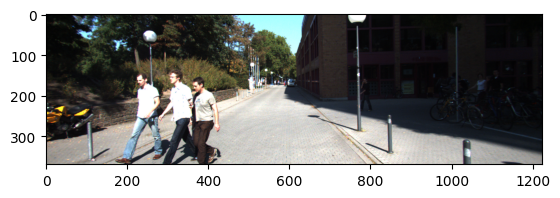

In [25]:
import glob

images_files = glob.glob("data/*.png")
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [26]:
def pipeline(img):
  with torch.no_grad():
    img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if torch.cuda.is_available():
      img_var = img_var.cuda()
    # segm, depth, norm = hydranet(img_var)
    segm, depth = hydranet(img_var)
    segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().numpy().transpose(1, 2, 0),
                      img.shape[:2][::-1],
                      interpolation=cv2.INTER_CUBIC)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                       img.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    # norm = cv2.resize(norm[0].cpu().data.numpy().transpose(1, 2, 0),
    #                    img.shape[:2][::-1],
    #                    interpolation=cv2.INTER_CUBIC)
    segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
    depth = np.abs(depth)

    # out_norm = norm / np.linalg.norm(norm, axis=2, keepdims=True)
    # ## xzy->RGB ##
    # out_norm[:, :, 0] = ((out_norm[:, :, 0] + 1.) / 2.) * 255.
    # out_norm[:, :, 1] = ((out_norm[:, :, 1] + 1.) / 2.) * 255.
    # out_norm[:, :, 2] = ((1. - out_norm[:, :, 2]) / 2.) * 255.
    # out_norm = out_norm.astype(np.uint8)

    # return segm, depth, out_norm
    return segm, depth

In [27]:
# segm, depth, normal = pipeline(img)
segm, depth = pipeline(img)

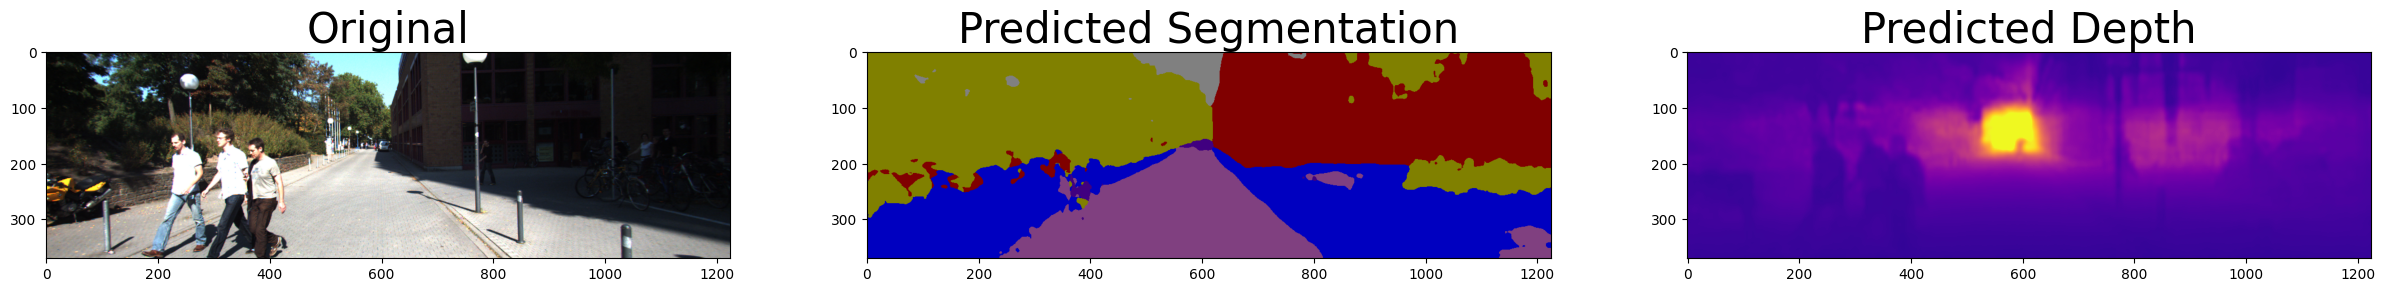

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

In [29]:
print(img.shape)
print(depth.shape)
print(segm.shape)

(370, 1224, 3)
(370, 1224)
(370, 1224, 3)


In [30]:
# plt.figure(figsize=(18, 12))
# plt.subplot(141)
# plt.imshow(img)
# plt.title('orig img')
# plt.axis('off')
# plt.subplot(142)
# plt.imshow(segm)
# plt.title('pred segm')
# plt.axis('off')
# plt.subplot(143)
# plt.imshow(depth, cmap="plasma", vmin=0, vmax=80)
# plt.title('pred depth')
# plt.axis('off')
# plt.subplot(144)
# plt.imshow(normal)
# plt.title('pred norm')
# plt.axis('off')

### Video

In [31]:
print(img.shape)
print(depth.shape)
print(segm.shape)

(370, 1224, 3)
(370, 1224)
(370, 1224, 3)


(370, 1224, 3)


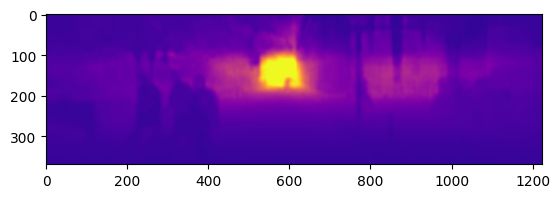

In [32]:
import matplotlib.cm as cm
import matplotlib.colors as co

def depth_to_rgb(depth):
  normalizer = co.Normalize(vmin=0, vmax=80)
  mapper = cm.ScalarMappable(norm=normalizer, cmap='plasma')
  colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
  return colormapped_im

depth_rgb = depth_to_rgb(depth)
print(depth_rgb.shape)
plt.imshow(depth_rgb)
plt.show()

(370, 1224, 3)
(370, 1224, 3)
(370, 1224, 3)


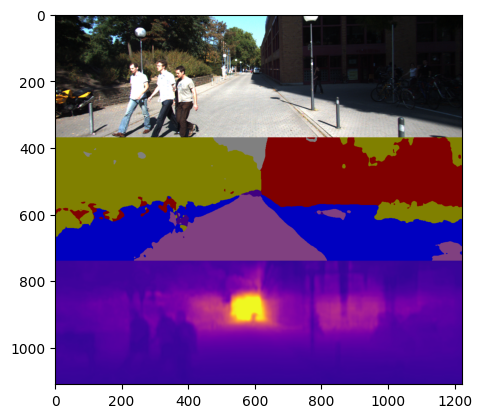

In [33]:
print(img.shape)
print(depth_rgb.shape)
print(segm.shape)
new_img = np.vstack((img, segm, depth_rgb))
plt.imshow(new_img)
plt.show()

In [37]:
video_files = sorted(glob.glob("data/*.png"))

hydranet = HydraNet()
hydranet.define_mobilenet()
hydranet.define_lightweight_refinenet()

if torch.cuda.is_available():
  _ = hydranet.cuda()
_ = hydranet.eval()

ckpt = torch.load("ExpKITTI_joint.ckpt")
hydranet.load_state_dict(ckpt["state_dict"])

result_video = []
for idx, img_path in enumerate(video_files):
  image = np.array(Image.open(img_path))
  h, w, _ = image.shape
  segm, depth = pipeline(image)

  result_video.append(cv2.cvtColor(cv2.vconcat([image, segm, depth_to_rgb(depth)]), cv2.COLOR_BGR2RGB))

out = cv2.VideoWriter('/content/drive/MyDrive/ColabNotebooks/Multi-Task-Learnin/out.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,3*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

<ipython-input-37-42331e24f775>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("ExpKITTI_joint.ckpt")
